In [1]:
source("/secure/projects/HTAPP_MBC/src/init.R")
library("LiblineaR")

Loading required package: cowplot

Attaching package: 'cowplot'

The following object is masked from 'package:ggplot2':

    ggsave

Loading required package: Matrix
Loading combined annotation: annot


In [2]:
wd=file.path(analysisDir,"00_spatial_probes")
dir.create(wd)
setwd(wd)

Warning message in dir.create(wd):
"'/scratch/projects/HTAPP_MBC//analysis//00_spatial_probes' already exists"

In [3]:
simpleCache(cacheName = "frozen_combined",
            instruction = "", 
            cacheDir = cacheDir, 
            cacheSubDir = "combined_seurat", 
            recreate = FALSE,assignToVariable = "cs")

Warning message in simpleCache(cacheName = "frozen_combined", instruction = "", :
"Detected a character instruction; consider wrapping in {} instead ofquotes."::Loading cache::	/scratch/projects/HTAPP_MBC//RCache//combined_seurat/frozen_combined.RData


In [8]:
#set "weird" cancer cells as separate cell type
lab_dt=as.data.table(cs@meta.data[,c("labels","labels_detail")],keep.rownames = "cellid")
lab_dt[,labels_mod:=ifelse(labels%in%c("Neuroepithelial_cell","Neurons","Astrocyte"),"Epithelial_neuro",labels),]
setnames(lab_dt,c("labels","labels_mod"),c("labels_orig","labels"))
lab_df=data.frame(lab_dt,row.names = "cellid")
cs=AddMetaData(cs,metadata = lab_df)

In [9]:
sort(table(cs@meta.data$labels))


                 GMP                   BM            Myelocyte 
                   4                    7                    8 
       Pro-Myelocyte           Neutrophil           BM & Prog. 
                   9                   14                   15 
        Erythroblast     Pro-B_cell_CD34+     Pre-B_cell_CD34- 
                  19                   35                   36 
                 CMP                  MEP            HSC_CD34+ 
                  41                   66                   78 
         Neutrophils           HSC_-G-CSF          Gametocytes 
                  83                  129                  186 
              B_cell                   DC                  MSC 
                 187                  194                  199 
   Tissue_stem_cells            Platelets            iPS_cells 
                 207                  209                  240 
       Keratinocytes          Osteoblasts         Chondrocytes 
                 329                  3

In [5]:
cell_types=c("Epithelial_cells","Epithelial_neuro","T_cells","Fibroblasts","Macrophage","B_cell","NK_cell","Endothelial_cells","Monocyte","Embryonic_stem_cells")

#### Get importance of each gene for the prediction of each of the other genes

In [ ]:
#run in console such that parallel computing can be used efficiently
#prepare
source("/secure/projects/HTAPP_MBC/src/init.R")
library("LiblineaR")
library(parallel)

wd=file.path(analysisDir,"00_spatial_probes")
dir.create(wd)
setwd(wd)

simpleCache(cacheName = "fresh_combined",
            instruction = "", 
            cacheDir = cacheDir, 
            cacheSubDir = "combined_seurat", 
            recreate = FALSE,assignToVariable = "cs")

#discriminate between b-cells and plasma cells
lab_dt=as.data.table(cs@meta.data[,c("labels","labels_detail")],keep.rownames = "cellid")
lab_dt[,labels_mod:=ifelse(labels=="B_cell"&labels_detail=="B_cell:Plasma_cell","Plasma_cell",labels),]
setnames(lab_dt,c("labels","labels_mod"),c("labels_orig","labels"))
lab_df=data.frame(lab_dt,row.names = "cellid")
cs=AddMetaData(cs,metadata = lab_df)

cs=SetIdent(cs,ident.use = cs@meta.data$labels)


cell_types=c("Epithelial_cells","T_cells","Fibroblasts","Macrophage","B_cell","NK_cell","Endothelial_cells","Monocyte","iPS_cells","Plasma_cell")

In [8]:
#function
get_weights=function(obj,ct,gene_list=NULL,cpi=1000,run_name=NULL){

    all_weights=data.table()

    message(paste0(Sys.time(),": ",ifelse(is.null(run_name),ct,run_name)))
    
    cells=WhichCells(obj,subset.name = "labels",accept.value = ct)    
    sub1=SubsetData(obj,cells.use = cells,max.cells.per.ident = cpi,random.seed = 1234)
    
    test_cells=cells[!cells%in%sub1@cell.names]
    if (length(test_cells)<500){
        missing=500-length(test_cells)
        add_from=length(cells)-length(test_cells)
        test_cells=c(test_cells,cells[!cells%in%test_cells][sample(1:add_from,min(missing,length(cells)))])
        message(paste0(ifelse(is.null(run_name),ct,run_name),": ",missing," test cells missing. Using ",length(test_cells)," cells."))
    }
    
    sub2=SubsetData(obj,cells.use = test_cells,max.cells.per.ident = cpi,random.seed = 2345)

    if (is.null(gene_list)){
        gene_list=FindVariableGenes(SubsetData(obj,cells.use = cells),y.cutoff = 0.1,set.var.genes=FALSE,do.plot=FALSE,display.progress = FALSE)
        message(paste0(ifelse(is.null(run_name),ct,run_name),": ",length(gene_list)," variable genes detected."))
    }
    
    dat=t(as.matrix(sub1@data))[,gene_list]  
    dat_test=t(as.matrix(sub2@data))[,gene_list]
    
    for (p_gene in gene_list){

        dat_x=dat[,!grepl(p_gene,colnames(dat))]
        dat_y=dat[,p_gene]

        dat_test_x=dat_test[,!grepl(p_gene,colnames(dat_test))]
        dat_test_y=dat_test[,p_gene]  

        #liblinear
        c=heuristicC(dat_x)
        mse_cv=LiblineaR(dat_x,dat_y,type = 13,cost = c,svr_eps=0.1,cross=5)
        m=LiblineaR(dat_x,dat_y,type = 13,cost = c,svr_eps=0.1)
        w_dt=as.data.table(t(m$W),keep.rownames = "gene")
        setnames(w_dt,"V1","weights")
        p=predict(m,newx = dat_test_x)
        oldw <- getOption("warn")
        options(warn=-1)
        c_l=cor.test(p$predictions,dat_test_y)
        options(warn=oldw)
        w_dt[,cell_type:=ifelse(is.null(run_name),ct,run_name),]
        
        w_dt[,pred_gene:=p_gene,]
        w_dt[,cor:=c_l$estimate,]
        w_dt[,pval:=c_l$p.value,]
        w_dt[,mse:=mse_cv,]
        w_dt[,mean_train:=mean(dat_y),]
        w_dt[,sd_train:=sd(dat_y),]
        w_dt[,mean_test:=mean(dat_test_y),]
        w_dt[,sd_test:=sd(dat_test_y),]
        w_dt[,ntrain:=length(sub1@cell.names),]
        w_dt[,ntest:=length(sub2@cell.names),]
        w_dt[,nsame:=sum(sub2@cell.names%in%sub1@cell.names),]
        all_weights=rbindlist(list(all_weights,w_dt))
       
        rm(m)
        rm(w_dt)
        rm(dat_test_x)
        rm(dat_test_y)
        rm(dat_x)
        rm(dat_y)
        gc()
    }
    
        save(all_weights,file=paste0("all_weights_",ifelse(is.null(run_name),ct,run_name),".RData"))
        return(paste0(ifelse(is.null(run_name),ct,run_name)," done."))
    
}

In [9]:
#run
#system.time(expr=res<-mclapply(cell_types,function(x)get_weights(cs,gene_list,x),mc.cores=8,mc.preschedule=FALSE))
#mclapply(cell_types,function(x)get_weights(cs,x),mc.cores=4,mc.preschedule=FALSE)
get_weights(cs,cell_types,cpi = 100,run_name = "all_ct")

2019-05-25 21:54:55: all_ct
all_ct: 4808 variable genes detected.


[1] "all_ct done."

#### Parse results and select genes

In [6]:
combined_weights=data.table()
for (ct in cell_types){
    load(paste0("all_weights_",ct,".RData"))
    dat=SubsetData(cs,ident.use = ct)@data[unique(all_weights$pred_gene),]
    means=rbindlist(apply(dat,1,function(x){return(data.table(mean=mean(x),sd=sd(x)))}),idcol="pred_gene")
    all_weights=merge(all_weights,means,by="pred_gene",all=TRUE)
    
    combined_weights=rbindlist(list(combined_weights,all_weights))
    rm(dat,means,all_weights)
    gc()
}

In [3]:
load("all_weights_all_ct.RData")

In [4]:
combined_weights=all_weights

In [5]:
head(combined_weights)

gene,weights,cell_type,pred_gene,cor,pval,mse,mean_train,sd_train,mean_test,sd_test,ntrain,ntest,nsame
AAAS,-0.0017729541,all_ct,A2M,0.692122,1.778197e-143,0.3031812,0.3695434,0.7879628,0.3283487,0.743902,1000,1000,0
AAED1,0.0145646851,all_ct,A2M,0.692122,1.778197e-143,0.3031812,0.3695434,0.7879628,0.3283487,0.743902,1000,1000,0
AAGAB,0.0025400766,all_ct,A2M,0.692122,1.778197e-143,0.3031812,0.3695434,0.7879628,0.3283487,0.743902,1000,1000,0
AAK1,0.0052318008,all_ct,A2M,0.692122,1.778197e-143,0.3031812,0.3695434,0.7879628,0.3283487,0.743902,1000,1000,0
AAMDC,-0.0143333187,all_ct,A2M,0.692122,1.778197e-143,0.3031812,0.3695434,0.7879628,0.3283487,0.743902,1000,1000,0
AAR2,-0.0004227297,all_ct,A2M,0.692122,1.778197e-143,0.3031812,0.3695434,0.7879628,0.3283487,0.743902,1000,1000,0


In [32]:
combined_weights[pred_gene=="KRT18"][order(-abs(weights))][1:5]

gene,weights,cell_type,pred_gene,cor,pval,mse,mean_train,sd_train,mean_test,sd_test,ntrain,ntest,nsame
KRT8,0.10962571,all_ct,KRT18,0.7137331,1.639742e-156,0.3747741,0.5177001,0.9313184,0.5430963,0.9491406,1000,1000,0
KRT19,0.07042839,all_ct,KRT18,0.7137331,1.639742e-156,0.3747741,0.5177001,0.9313184,0.5430963,0.9491406,1000,1000,0
SCGB1D2,0.05182710,all_ct,KRT18,0.7137331,1.639742e-156,0.3747741,0.5177001,0.9313184,0.5430963,0.9491406,1000,1000,0
XBP1,0.05006523,all_ct,KRT18,0.7137331,1.639742e-156,0.3747741,0.5177001,0.9313184,0.5430963,0.9491406,1000,1000,0
TPD52,0.04947818,all_ct,KRT18,0.7137331,1.639742e-156,0.3747741,0.5177001,0.9313184,0.5430963,0.9491406,1000,1000,0


#### Check prediction

In [6]:
#combined_weights_red=combined_weights[,.(N_train=.N),by=c("cell_type","pred_gene","cor","pval","mse","ntrain","ntest","nsame","mean","sd")]
combined_weights_red=combined_weights[,.(N_train=.N),by=c("cell_type","pred_gene","cor","pval","mse","ntrain","ntest","nsame","mean_train","sd_train","mean_test","sd_test")]

In [7]:
#combined_weights_red[,mse_norm:=mse/sd^2,by=c("cell_type","pred_gene")]
combined_weights_red[,mse_norm:=mse/sd_train^2,by=c("cell_type","pred_gene")]

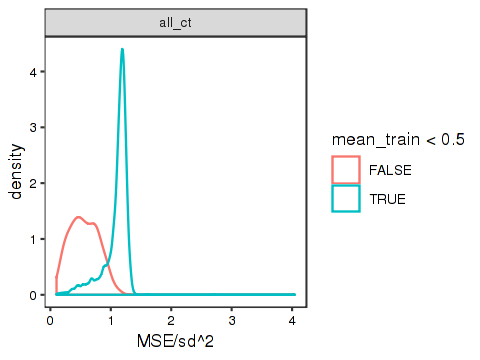

In [35]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(combined_weights_red,aes(x=mse_norm,col=mean_train<0.5))+geom_density()+facet_wrap(~cell_type,scale="free",ncol=5)+xlab("MSE/sd^2")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


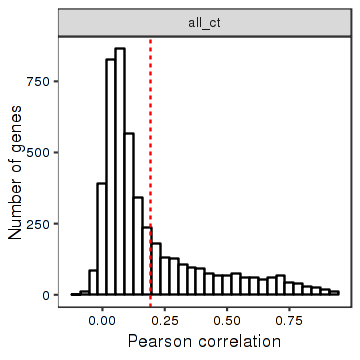

In [28]:
options(repr.plot.width = 3, repr.plot.height = 3)
ggplot(combined_weights_red,aes(x=cor))+geom_histogram(col="black", fill="white")+facet_wrap(~cell_type,scale="free",ncol=5)+
geom_vline(xintercept = mean(combined_weights_red$cor,na.rm = TRUE),col="red",lty=2)+xlab("Pearson correlation")+ylab("Number of genes")

In [24]:
combined_weights_red[,mean(cor,na.rm = TRUE),by="cell_type"]

cell_type,V1
all_ct,0.1915109


In [15]:
combined_weights_red[,mean(mean,na.rm = TRUE),by="cell_type"]

cell_type,V1
Epithelial_cells,0.1890629
T_cells,0.1311824
Fibroblasts,0.1691304
Macrophage,0.1658526
B_cell,0.1338899
NK_cell,0.1293151
Endothelial_cells,0.1566112
Monocyte,0.1743331
iPS_cells,0.2270651
Plasma_cell,0.2281025


In [21]:
combined_weights_red[,cor(cor,mse,use="complete"),by="cell_type"]

cell_type,V1
Epithelial_cells,0.5687985
T_cells,0.5301812
Fibroblasts,0.4267968
Macrophage,0.6463019
B_cell,0.4508271
NK_cell,0.5266696
Endothelial_cells,0.6040248
Monocyte,0.5871008
iPS_cells,0.5700640
Plasma_cell,0.2219156


In [9]:
combined_weights_red[,cor(cor,mean,use="complete"),by="cell_type"]

cell_type,V1
Epithelial_cells,0.5289217
T_cells,0.6810107
Fibroblasts,0.3160820
Macrophage,0.6692378
B_cell,0.6658627
NK_cell,0.6132722
Endothelial_cells,0.6058857
Monocyte,0.6538015
iPS_cells,0.6551502
Plasma_cell,0.5425758


In [11]:
combined_weights_red[cell_type=="Epithelial_cells"&cor>0.8]

cell_type,pred_gene,cor,pval,mse,ntrain,ntest,nsame,N_train
Epithelial_cells,ADIRF,0.8831615,0.000000e+00,0.39698493,1000,1000,0,4778
Epithelial_cells,AGTR1,0.8043215,7.538463e-228,0.06551059,1000,1000,0,4778
Epithelial_cells,AMD1,0.8080529,1.414450e-231,0.25589344,1000,1000,0,4775
Epithelial_cells,AQP5,0.8153922,3.764469e-239,0.21705197,1000,1000,0,4778
Epithelial_cells,AZGP1,0.8115352,3.962944e-235,0.68445404,1000,1000,0,4778
Epithelial_cells,BASP1,0.8568363,2.227688e-289,0.24121033,1000,1000,0,4778
Epithelial_cells,BPIFB2,0.8551233,5.326251e-287,0.16080438,1000,1000,0,4778
Epithelial_cells,BTG2,0.8306702,4.603387e-256,0.49813508,1000,1000,0,4778
Epithelial_cells,CALML5,0.9454066,0.000000e+00,0.25622010,1000,1000,0,4778
Epithelial_cells,CARTPT,0.9635517,0.000000e+00,0.11230890,1000,1000,0,4778


In [23]:
combined_weights_red[cell_type=="Epithelial_cells"&pred_gene=="GAPDH"]

cell_type,pred_gene,cor,pval,mse,ntrain,ntest,nsame,N_train
Epithelial_cells,GAPDH,0.7384163,5.728827e-173,0.2422871,1000,1000,0,4778


In [30]:
combined_weights_red[cor>0.7,.N,by="cell_type"]

cell_type,N
Epithelial_cells,175
T_cells,11
Fibroblasts,5025
Macrophage,31
B_cell,6
NK_cell,17
Endothelial_cells,32
Monocyte,39
iPS_cells,51
Plasma_cell,1232


In [20]:
good=combined_weights_red[cor>0.7,.N,by="pred_gene"]

In [26]:
table(good$N)


   1    2    3    4    5    6    8    9   10 
5460  436   41   15    7    1    3    1    3 

In [29]:
good[N==8]

pred_gene,N
MT-CO2,8
MT-ND1,8
MT-ND3,8
